# Training Models

In this section we will train models to predict house prices. To strech fistly I tried to fir simle OLS Regression both with applying formula and with libraries(statmodels and seaborn).

After that I tried every model as default and with grid search I reported all results after every model. Lets look at file structer.

| Model                                            | Library - Framework |
| :----------------------------------------------- | :-----------------: |
| Multiple Regression                              |    scikit-learn    |
| Polinomial Regression                            |    scikit-learn    |
| Lasso Regression (l1 regularization)             |    scikit-learn    |
| Ridge Regression (l2 regularization)             |    scikit-learn    |
| ElasticNet Regression (l1 and l2 regularization) |    scikit-learn    |
| Support Vector Regression                        |    scikit-learn    |
| Decision Tree                                    |    scikit-learn    |
| Random Forest                                    |    scikit-learn    |
| Ada Boost                                        |    scikit-learn    |
| Gradient Boosting                                |    scikit-learn    |
| eXtreme Gradient Boosting                        |       XGBoost       |
| Neural Network                                   |     TensorFlow     |


### Load & Prepare Data

In models data will used as both scaled and unscaled. To scale data I used standart scaler which calculates every feature Z score with training data set statistics.

##### Data preparation - Trains Test Split and Feature Scaling
I didnt scale as Z scores dummy variables because they already 0-1 normalized. You can see below scaling data decrase test performance because of that on grid search only unsclaed daya used.

In [59]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import (residual_plots, html_table,
                       reg_score_table, residual_plot)

pd.set_option('float_format', '{:f}'.format)

processed_data_dir = Path('../data/processed/')
file_name = 'train.csv'
file_path = processed_data_dir / file_name
models_trained_dir = Path('../models/trained/')

In [60]:
df = pd.read_csv(file_path)
df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.000000,8450,7,5,2003,2003,196.000000,706,0,150,...,0,0,0,0,1,0,0,0,1,0
1,80.000000,9600,6,8,1976,1976,0.000000,978,0,284,...,0,0,0,0,1,0,0,0,1,0
2,68.000000,11250,7,5,2001,2002,162.000000,486,0,434,...,0,0,0,0,1,0,0,0,1,0
3,60.000000,9550,7,5,1915,1970,0.000000,216,0,540,...,0,0,0,0,1,0,0,0,0,0
4,84.000000,14260,8,5,2000,2000,350.000000,655,0,490,...,0,0,0,0,1,0,0,0,1,0


In [62]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']
cont_cols = X.columns[:list(X.columns).index('YrSold') + 1]

In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

In [94]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)
print(X_train_scaled.shape)
print(X_train.shape)
print(X_test_scaled.shape)
print(X_test.shape)

(1153, 254)
(1153, 254)
(289, 254)
(289, 254)


### Try simple OLS
In this section I will try Ordinary Least Square Regression with formula and demostrate results differents way.

##### Custom Calculation

In [65]:
x_ols = df['GrLivArea'].values
y_ols = df['SalePrice'].values
# np.polyfit(x,y,deg=1)
x_mean = x_ols.mean()
y_mean = y_ols.mean()
x_me = x_ols - x_mean
y_me = y_ols - y_mean
x_sme = np.sum(x_me ** 2)
m = np.sum(x_me * y_me) / x_sme
b = y_mean - m * x_mean
print(f'y_hat_i = {np.round(m, decimals=3)}*x_i + {np.round(b, decimals=3)}')

y_hat_i = 97.269*x_i + 31670.473


In [66]:
y_pred = x_ols * m + b
R2 = 1 - (np.sum((y - y_pred) ** 2) / np.sum(y_me ** 2))

print(
    f'GrLivArea describe {np.round(R2, decimals=4) * 100}% of SalePrice\'s varience.')

GrLivArea describe 47.4% of SalePrice's varience.


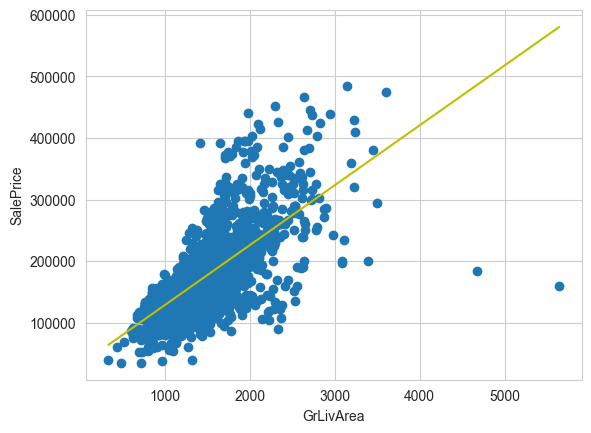

In [67]:
fig, ax = plt.subplots()
line_x = np.array([np.min(x_ols), np.max(x_ols)])
line_y = line_x * m + b
ax.plot(line_x, line_y, color='y')
ax.scatter(x_ols, y_ols)
ax.set_ylabel('SalePrice')
ax.set_xlabel('GrLivArea')
plt.show()

##### Calculation with Libraries

In [68]:
import statsmodels.api as sm

x_ols = sm.add_constant(x_ols)
results = sm.OLS(y_ols, x_ols).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     1297.
Date:                Tue, 29 Nov 2022   Prob (F-statistic):          4.12e-203
Time:                        13:19:19   Log-Likelihood:                -17704.
No. Observations:                1442   AIC:                         3.541e+04
Df Residuals:                    1440   BIC:                         3.542e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.167e+04   4285.965      7.389      0.0

<AxesSubplot: xlabel='GrLivArea', ylabel='SalePrice'>

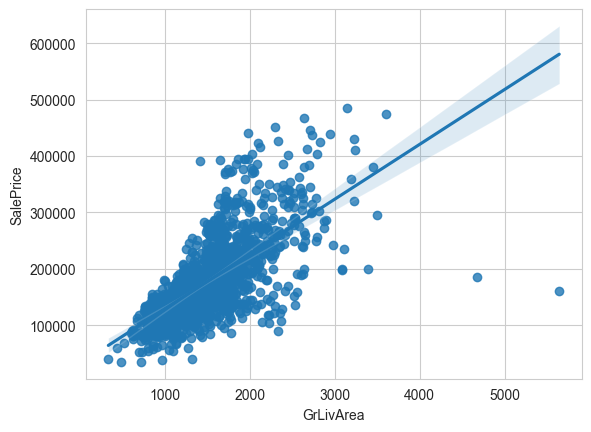

In [69]:
sns.regplot(x='GrLivArea', y='SalePrice', data=df)

## Trainin Performance Purpose Model

### Regression Models

#### Multiple Linear Regression Models

Compare models performance on scaled and normal data.

In [95]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV

,Train Normal,Test Normal,Train Scaled,Test Scaled
R2,0.940377,0.615974,0.940377,-255042413573213683712.000000
MAE,12000.640586,18451.556543,12001.268948,64297260554752.484375
MSE,312338591.820168,1798359408.638859,312339947.016520,1194339849369502537382147129344.000000
RMSE,17673.103627,42407.067909,17673.141968,1092858567871205.625000


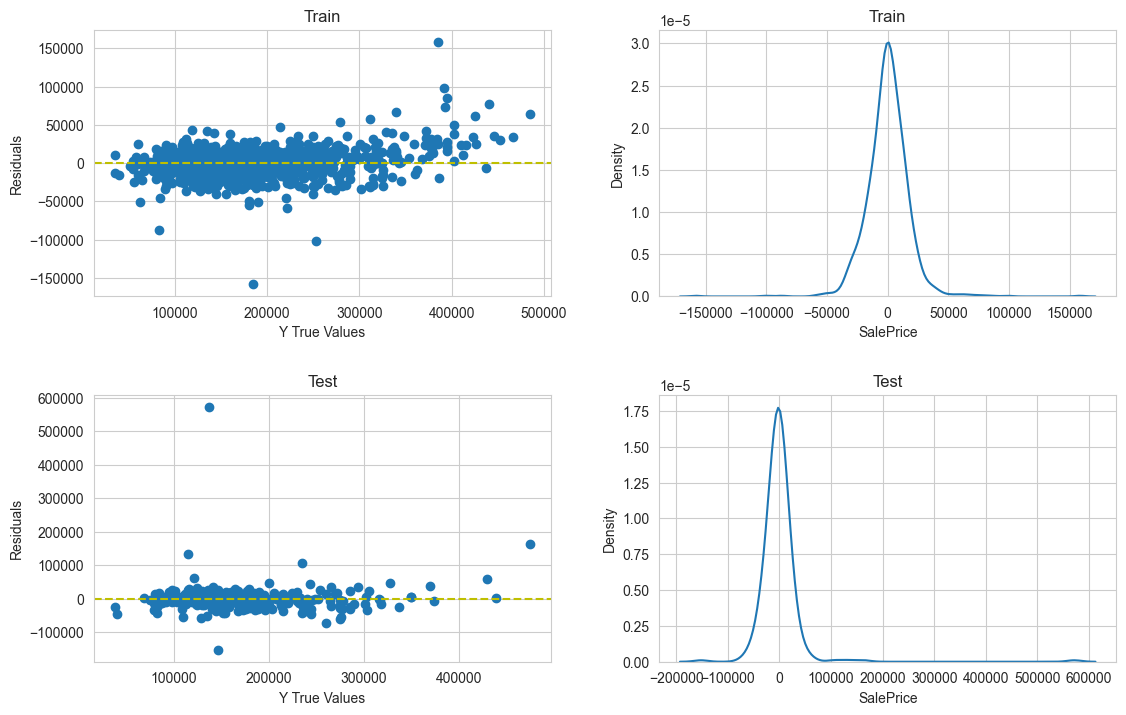

In [96]:
lin = LinearRegression()
lin.fit(X_train, y_train)
lin_scaled = LinearRegression()
lin_scaled.fit(X_train_scaled, y_train)

lin_score = reg_score_table(lin, X_train, X_test, y_train, y_test)
lin_score.columns += ' Normal'
lin_scaled_score = reg_score_table(lin_scaled, X_train_scaled, X_test_scaled,
                                   y_train, y_test)
lin_scaled_score.columns += ' Scaled'

scores = pd.concat([lin_score, lin_scaled_score], axis=1)
html_table(scores)
residual_plots(lin, X_train, X_test, y_train, y_test)

#### Polynomial Linear Regression Model

In [103]:
from sklearn.preprocessing import PolynomialFeatures

polynomial_converter = PolynomialFeatures()
polynomial_converter.fit(X)
X_poly = polynomial_converter.transform(X)
print('Dataset features shape is: ', X_poly.shape)
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly,
                                                                        y,
                                                                        test_size=0.2,
                                                                        random_state=43)

sc_poly = StandardScaler()
sc_poly.fit(X_train_poly)
X_train_poly_scaled = sc_poly.transform(X_train_poly)
X_test_poly_scaled = sc_poly.transform(X_test_poly)

poly_reg = LinearRegression()
poly_reg.fit(X_train_poly_scaled, y_train_poly)

scores = reg_score_table(poly_reg, X_train_poly_scaled, X_test_poly_scaled,
                         y_train_poly,
                         y_test_poly)
html_table(scores)

Dataset features shape is:  (1442, 32640)


,Train,Test
R2,1.000000,0.583339
MAE,0.000000,24394.658814
MSE,0.000000,2356033961.833591
RMSE,0.000000,48538.994240


#### Grid Search on Linear Regression and Regularizations

In [161]:

def fit_eval_grid_gen(X_train, X_test, y_train, y_test, **kwargs):
    def fit_eval_grid(model, param_grid, title):
        grid = GridSearchCV(model, param_grid, cv=5,
                            n_jobs=-1, verbose=3, **kwargs)
        grid.fit(X_train, y_train)
        print('\n\rBest params are: ', grid.best_params_, '\n')
        scores = reg_score_table(grid, X_train, X_test, y_train,
                                 y_test)
        scores.columns += f' {title}'
        html_table(scores)
        return grid, scores

    return fit_eval_grid


In [163]:
fit_eval_grid_reg = fit_eval_grid_gen(X_train_scaled, X_test_scaled, y_train,
                                      y_test,
                                      **{'scoring': 'neg_mean_squared_error'})

##### Lasso

In [164]:
lasso_model = Lasso(max_iter=int(1e+4))
lasso_param_grid = {'alpha': np.logspace(-3, 2, 10)}
lasso_grid, lasso_scores = fit_eval_grid_reg(lasso_model, lasso_param_grid,
                                             'Lasso')

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best params are:  {'alpha': 100.0} 



,Train Lasso,Test Lasso
R2,0.936686,0.731407
MAE,12422.822151,16370.302986
MSE,331676770.179360,1257797250.202471
RMSE,18211.995228,35465.437403


##### Ridge

In [165]:
ridge_model = Ridge(max_iter=int(1e+4))
ridge_param_grid = {'alpha': np.logspace(-3, 2, 10)}
ridge_grid, ridge_scores = fit_eval_grid_reg(ridge_model, ridge_param_grid,
                                             'Ridge')

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best params are:  {'alpha': 100.0} 



,Train Ridge,Test Ridge
R2,0.918267,0.872525
MAE,13968.155142,16085.391482
MSE,428162612.651813,596951970.784400
RMSE,20692.090582,24432.600574


##### ElasticNet

In [146]:
elastic_model = ElasticNet(max_iter=int(1e+3))
elastic_param_grid = {'alpha': [0.1, 1, 5, 10, 50, 100],
                      'l1_ratio': [.1, .5, .7, .9, .95, .99, 1]}
elastic_grid, elastic_scores = fit_eval_grid_reg(elastic_model,
                                                 elastic_param_grid,
                                                 'Elastic')

Fitting 5 folds for each of 42 candidates, totalling 210 fits

Best params are:  {'alpha': 50, 'l1_ratio': 0.99} 



,Train Elastic,Test Elastic
R2,0.890158,0.874568
MAE,15550.799064,15968.448332
MSE,575415812.967642,587386872.839697
RMSE,23987.826349,24236.065540


### Support Vector Regression

In [111]:
from sklearn.svm import SVR

param_grid = {'C': [0.001, 0.01, 0.1, 0.5, 1],
              'kernel': ['linear', 'rbf', 'poly'],
              'gamma': ['scale', 'auto'],
              'degree': [2, 3, 4],
              'epsilon': [0, 0.01, 0.1, 0.5, 1, 2]}

svr = SVR()
svr_grid = GridSearchCV(svr, param_grid=param_grid, n_jobs=-1, verbose=3)
svr_grid.fit(X_train_scaled, y_train)

print('\n\rBest params are: ', svr_grid.best_params_, '\n')
svr_scores = reg_score_table(svr, X_train_scaled, X_test_scaled, y_train,
                             y_test)
svr_scores.columns += ' SVR'
html_table(scores)

### Tree Based Models

In [166]:
fit_eval_grid_tree = fit_eval_grid_gen(X_train, X_test, y_train, y_test)

#### Decision Tree Regressor

In [169]:
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor()
param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': [5, 10, 30, 50, 100, 150, 300],
    'min_samples_split': [3, 5, 10],
    'min_impurity_decrease': np.logspace(-2, 0, 10)
}
tree_grid, tree_scores = fit_eval_grid_tree(tree_model, param_grid,
                                            'Decision Tree')

Fitting 5 folds for each of 840 candidates, totalling 4200 fits

Best params are:  {'criterion': 'poisson', 'max_depth': 5, 'min_impurity_decrease': 0.21544346900318834, 'min_samples_split': 5} 



,Train Decision Tree,Test Decision Tree
R2,0.855101,0.754730
MAE,20304.440556,23872.688329
MSE,759064654.046499,1148576835.538706
RMSE,27551.128000,33890.660004


#### Random Forest Regressor

In [172]:
from sklearn.ensemble import RandomForestRegressor

rfr_model = RandomForestRegressor()
param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': [5, 50, 150, 300],
    'min_impurity_decrease': np.logspace(-2, 0, 4),
    'n_estimators': [50, 100, 200]
}
rfr_grid, RFR_scores = fit_eval_grid_tree(rfr_model, param_grid,
                                          'Random Forest')

Fitting 5 folds for each of 192 candidates, totalling 960 fits

Best params are:  {'criterion': 'poisson', 'max_depth': 50, 'min_impurity_decrease': 0.21544346900318834, 'n_estimators': 100} 



,Train Random Forest,Test Random Forest
R2,0.981256,0.857428
MAE,6554.562565,16714.784635
MSE,98192179.624287,667649312.619810
RMSE,9909.196719,25838.910825


#### AdaBoost Regressor

In [176]:
from sklearn.ensemble import AdaBoostRegressor

abr_model = AdaBoostRegressor()
param_grid = {
    'loss': ['linear', 'square', 'exponential'],
    'n_estimators': [200, 500, 1000],
    'learning_rate': [0.1, 1., 10.],
}
abr_grid, abr_scores = fit_eval_grid_tree(abr_model, param_grid,
                                          'AdaBoost')

Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best params are:  {'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 1000} 



,Train AdaBoost,Test AdaBoost
R2,0.890364,0.807874
MAE,19170.180250,21891.355012
MSE,574333732.948922,899709681.238046
RMSE,23965.260961,29995.160964


#### Gradient Boosting Regressor

In [177]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = GradientBoostingRegressor()
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_impurity_decrease': [0.21544],
}
gbr_grid, gbr_scores = fit_eval_grid_tree(gbr_model, param_grid,
                                          'Gradient Boosting')

Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best params are:  {'max_depth': 3, 'min_impurity_decrease': 0.21544, 'n_estimators': 200} 



,Train Gradient Boosting,Test Gradient Boosting
R2,0.979877,0.876217
MAE,7765.516946,14673.954881
MSE,105413784.748841,579664733.004282
RMSE,10267.121542,24076.227549


#### eXtreme Gradient Boosting

In [180]:
import xgboost as xgb

xgbr_model = xgb.XGBRegressor()
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
}
xgbr_grid, xgbr_scores = fit_eval_grid_tree(xgbr_model, param_grid,
                                            'eXtreme Gradient Boosting')

Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best params are:  {'max_depth': 3, 'n_estimators': 200} 



,Train eXtreme Gradient Boosting,Test eXtreme Gradient Boosting
R2,0.994308,0.876909
MAE,4113.446563,15556.846710
MSE,29817833.231299,576425244.664678
RMSE,5460.570779,24008.857629


### Neural Network

In [187]:
import tensorflow as tf
from tensorflow.keras import regularizers

In [232]:
def model_init():
    inputs = tf.keras.Input(shape=(X_train_scaled.shape[1]))

    outputs = tf.keras.layers.Dense(1,
                                    kernel_regularizer=regularizers.L1L2(
                                        l1=1e-5, l2=1e-4),
                                    bias_regularizer=regularizers.L2(1e-4),
                                    activity_regularizer=regularizers.L2(1e-5))(
        inputs)
    return tf.keras.Model(inputs=inputs, outputs=outputs)


model = model_init()
model.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 254)]             0         
                                                                 
 dense_52 (Dense)            (None, 1)                 255       
                                                                 
Total params: 255
Trainable params: 255
Non-trainable params: 0
_________________________________________________________________


In [236]:
@tf.function
def r2_score(y_true, y_pred):
    numerator = tf.reduce_sum(tf.square(y_true - y_pred))
    denominator = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - (numerator / denominator)


optimizer = tf.keras.optimizers.SGD(0.1)
metric = r2_score
model.compile(optimizer=optimizer,
              metrics=[metric])
history = model.fit(x=X_train_scaled, y=y_train,
                    epochs=1000,
                    validation_data=(X_test_scaled, y_test),
                    batch_size=X_train.shape[0],
                    verbose=1
                    )

Epoch 1/1000
1/1 [==============================] - 0s 361ms/step - loss: 4.2288e-06 - r2_score: -6.1417 - val_loss: 4.2262e-06 - val_r2_score: -6.3409
Epoch 2/1000
1/1 [==============================] - 0s 31ms/step - loss: 4.2261e-06 - r2_score: -6.1417 - val_loss: 4.2234e-06 - val_r2_score: -6.3409
Epoch 3/1000
1/1 [==============================] - 0s 32ms/step - loss: 4.2234e-06 - r2_score: -6.1417 - val_loss: 4.2207e-06 - val_r2_score: -6.3409
Epoch 4/1000
1/1 [==============================] - 0s 31ms/step - loss: 4.2207e-06 - r2_score: -6.1417 - val_loss: 4.2180e-06 - val_r2_score: -6.3409
Epoch 5/1000
1/1 [==============================] - 0s 31ms/step - loss: 4.2179e-06 - r2_score: -6.1417 - val_loss: 4.2153e-06 - val_r2_score: -6.3409
Epoch 6/1000
1/1 [==============================] - 0s 47ms/step - loss: 4.2152e-06 - r2_score: -6.1417 - val_loss: 4.2126e-06 - val_r2_score: -6.3409
Epoch 7/1000
1/1 [==============================] - 0s 47ms/step - loss: 4.2125e-06 - r2_scor

### Deploying Model
There isnt to much difference between lasso, ridge, ElasticNet but ElasticNet test performance slightly better so our final model will be ElasticNet

In [92]:
all_scores = pd.concat((lin_score, lasso_scores, ridge_scores, elastic_scores),
                       axis=1)
html_table(all_scores)

,Train Normal,Test Normal,Train Lasso,Test Lasso,Train Ridge,Test Ridge,Train Elastic,Test Elastic
R2,0.940377,0.615974,0.936696,0.730270,0.918308,0.873559,0.890225,0.875351
MAE,12000.640586,18451.556543,12415.307130,16329.564467,13957.424772,16004.993744,15561.236428,15936.998919
MSE,312338591.820168,1798359408.638859,331620637.615475,1263122305.222474,427949589.899582,592109405.721675,575065405.645515,583720272.128539
RMSE,17673.103627,42407.067909,18210.454075,35540.431979,20686.942498,24333.298291,23980.521380,24160.303643


,Train
R2,0.901919
MAE,14507.965186
MSE,503662326.921765
RMSE,22442.422483


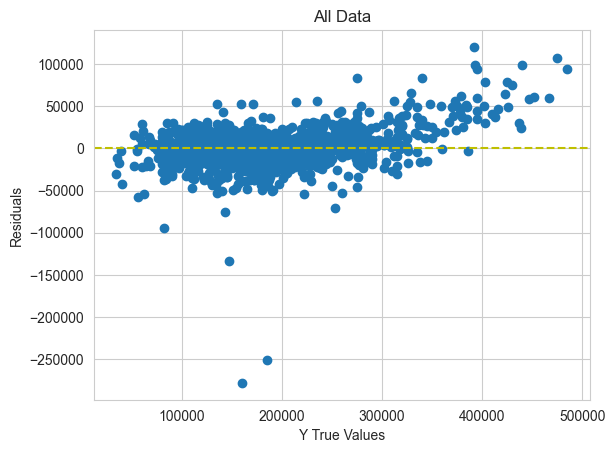

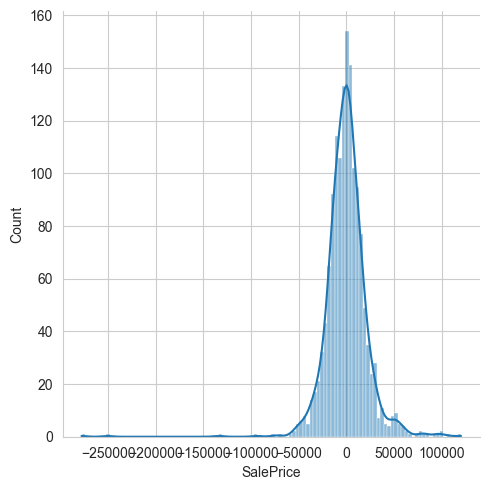

In [16]:
best_params_ = elastic_grid.best_params_
final_model = ElasticNet(**best_params_, max_iter=int(1e+8))
final_model.fit(X, y)
final_scores = reg_score_table(final_model, X, X, y, y).drop('Test', axis=1)
html_table(final_scores)
residuals = y - final_model.predict(X)
residual_plot(y, residuals, title='All Data')
sns.displot(residuals, kde=True)
plt.show()

In [17]:
from joblib import dump
import json

model_path = models_trained_dir / '0.1-os-elasticnet.joblib'
dump(final_model, model_path)

with open(models_trained_dir / '0.1-os-elasticnet-params.json', 'wt') as f:
    json.dump(elastic_grid.best_params_, f)